In [1]:
%pip install git+https://github.com/Gattocrucco/bartz.git

  Cloning https://github.com/Gattocrucco/bartz.git to /tmp/pip-req-build-nroj18hb
  Running command git clone --filter=blob:none --quiet https://github.com/Gattocrucco/bartz.git /tmp/pip-req-build-nroj18hb
  Resolved https://github.com/Gattocrucco/bartz.git to commit d2d2079c6e36677c6076aa7e06475cac042cca33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bartz: filename=bartz-0.1.0-py3-none-any.whl size=29182 sha256=90071436b53081c178971754525189a1ff5d72bcb2807f31695c81eab7f82177
  Stored in directory: /tmp/pip-ephem-wheel-cache-cr_lf93f/wheels/8f/5f/d1/f93d2aa58c0b61303bf15bd2ab8cee51acf8251e108d3357d4
Successfully built bartz


In [2]:
import jax
print(jax.__version__)
print(jax.devices('cpu'))
print(jax.devices('gpu'))

0.4.23
[CpuDevice(id=0)]
[cuda(id=0)]


n = 100, cpu: 0.0046s, gpu: 0.0093s
n = 200, cpu: 0.0012s, gpu: 0.0057s
n = 500, cpu: 0.0014s, gpu: 0.0051s
n = 1000, cpu: 0.0015s, gpu: 0.0054s
n = 2000, cpu: 0.0016s, gpu: 0.0086s
n = 5000, cpu: 0.0019s, gpu: 0.011s
n = 10000, cpu: 0.0026s, gpu: 0.027s
n = 20000, cpu: 0.0033s, gpu: 0.063s
n = 50000, cpu: 0.0053s, gpu: 0.28s
n = 100000, cpu: 0.011s, gpu: 0.0056s
n = 200000, cpu: 0.015s, gpu: 0.0059s
n = 500000, cpu: 0.034s, gpu: 0.0072s
n = 1000000, cpu: 0.052s, gpu: 0.0093s
n = 2000000, cpu: 0.1s, gpu: 0.014s
n = 5000000, cpu: 0.21s, gpu: 0.026s
n = 10000000, cpu: 0.43s, gpu: 0.047s
n = 20000000, cpu: 0.81s, gpu: 0.089s
n = 50000000, cpu: 2.1s, gpu: 0.21s
n = 100000000, cpu: 3.8s, gpu: 0.38s
n = 200000000, cpu: 7.8s, gpu: 0.7s
n = 500000000, cpu: 20s, gpu: 1.7s
n = 1000000000, cpu: 38s, gpu: 3.3s


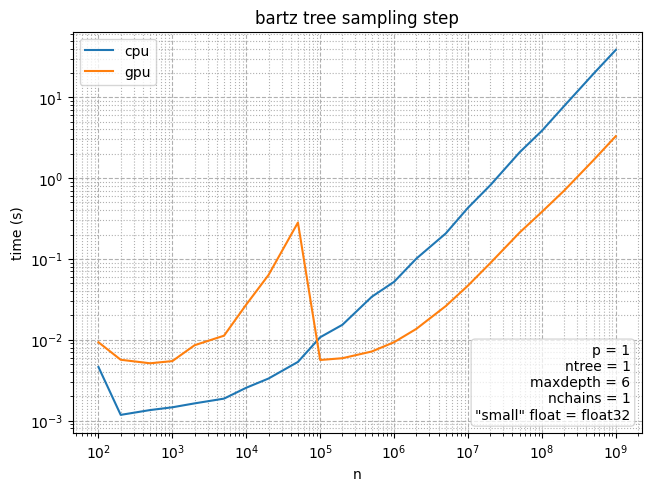

In [2]:
import time
import functools
import gc

import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt
import bartz

# Devices to benchmark on
devices = {
    'cpu': jax.devices('cpu')[0],
    'gpu': jax.devices('gpu')[0],
}

# BART config
ntree = 1
maxdepth = 6
nchains = 1
dtype = jnp.float32

# DGP config
p = 1 # number of predictors
nvec = [ # number of datapoints
    100,
    200,
    500,
    1000,
    2000,
    5000,
    10_000,
    20_000,
    50_000,
    100_000,
    200_000,
    500_000,
    1000_000,
    2000_000,
    5000_000,
    10_000_000,
    20_000_000,
    50_000_000,
    100_000_000,
    200_000_000,
    500_000_000,
    1000_000_000,
]

@functools.partial(jax.jit, static_argnums=(0, 1))
def gen_data(p, n):
    X = jnp.arange(p * n, dtype=jnp.uint8).reshape(p, n)
    max_split = jnp.full(p, 255, jnp.uint8)
    y = jnp.arange(n, dtype=jnp.int8) / dtype(255)
    return X, y, max_split

# random seed
key = random.key(202403251819)

class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    def __exit__(self, *_):
        self.time = time.perf_counter() - self.start

times = {}
for n in nvec:

    print(f'n = {n}', end='', flush=True)

    # generate data
    X, y, max_split = gen_data(p, n)

    # build initial mcmc state
    state = bartz.mcmcstep.init(
        X=X,
        y=y,
        max_split=max_split,
        num_trees=ntree,
        p_nonterminal=jnp.ones(maxdepth - 1),
        sigma2_alpha=1,
        sigma2_beta=1,
        small_float=dtype,
        min_points_per_leaf=1,
    )
    del X, y

    # repeat for each device
    for label, device in devices.items():

        # commit inputs to the target device
        keys = random.split(key, nchains)
        state, keys = jax.device_put((state, keys), device)
        gc.collect() # to delete copy of state on previous device

        # pre-compile mcmc loop
        @jax.jit
        @functools.partial(jax.vmap, in_axes=(None, 0))
        def task(state, key):
            return bartz.mcmcstep.sample_trees(state, key)
        task = task.lower(state, keys).compile()

        # clock
        with Timer() as timer:
            jax.block_until_ready(task(state, keys))

        # save result
        times.setdefault(label, []).append(timer.time)
        print(f', {label}: {timer.time:.2g}s', end='', flush=True)

    del state
    gc.collect()

    print()

def textbox(ax, text, loc='lower left', **kw):
    """
    Draw a box with text on a matplotlib plot.

    Parameters
    ----------
    ax : matplotlib axis
        The plot where the text box is drawn.
    text : str
        The text.
    loc : str
        The location of the box. Format: 'lower/center/upper left/center/right'.

    Keyword arguments
    -----------------
    Additional keyword arguments are passed to ax.annotate. If you pass a
    dictionary for the `bbox` argument, the defaults are updated instead of
    resetting the bounding box properties.

    Return
    ------
    The return value is that from ax.annotate.
    """

    M = 8
    locparams = {
        'lower left'   : dict(xy=(0  , 0  ), xytext=( M,  M), va='bottom', ha='left'  ),
        'lower center' : dict(xy=(0.5, 0  ), xytext=( 0,  M), va='bottom', ha='center'),
        'lower right'  : dict(xy=(1  , 0  ), xytext=(-M,  M), va='bottom', ha='right' ),
        'center left'  : dict(xy=(0  , 0.5), xytext=( M,  0), va='center', ha='left'  ),
        'center center': dict(xy=(0.5, 0.5), xytext=( 0,  0), va='center', ha='center'),
        'center right' : dict(xy=(1  , 0.5), xytext=(-M,  0), va='center', ha='right' ),
        'upper left'   : dict(xy=(0  , 1  ), xytext=( M, -M), va='top'   , ha='left'  ),
        'upper center' : dict(xy=(0.5, 1  ), xytext=( 0, -M), va='top'   , ha='center'),
        'upper right'  : dict(xy=(1  , 1  ), xytext=(-M, -M), va='top'   , ha='right' ),
    }

    kwargs = dict(
        xycoords='axes fraction',
        textcoords='offset points',
        bbox=dict(
            facecolor='white',
            alpha=0.75,
            edgecolor='#ccc',
            boxstyle='round'
        ),
    )
    kwargs.update(locparams[loc])

    newkw = dict(kw)
    for k, v in kw.items():
        if isinstance(v, dict) and isinstance(kwargs.get(k, None), dict):
            kwargs[k].update(v)
            newkw.pop(k)
    kwargs.update(newkw)

    return ax.annotate(text, **kwargs)

# plot execution time
fig, ax = plt.subplots(num='benchmark-device', clear=True, layout='constrained')

times_array = jnp.array(list(times.values())).T
ax.plot(nvec, times_array, label=list(times.keys()))
ax.legend(loc='upper left')
ax.set(
    title='bartz tree sampling step',
    xlabel='n',
    ylabel='time (s)',
    xscale='log',
    yscale='log',
)
ax.grid(linestyle='--')
ax.grid(which='minor', linestyle=':')
textbox(ax, f"""\
p = {p}
ntree = {ntree}
maxdepth = {maxdepth}
nchains = {nchains}
"small" float = {dtype.dtype}""", loc='lower right')

fig.show()